In [38]:
import numpy as np
import pandas as pd
import load_data as ld
import preprocess as pre
from numpy.linalg import norm
import networkx as nx
import operator
import dijkstra as d
import kruskal as k
import PFNET
from textrank import KeywordSummarizer


def cos_similarity(lst1, lst2):
    return np.dot(lst1, lst2)/(norm(lst1)*norm(lst2))

def rescale(num, maxNum):
    return maxNum - (maxNum-1)*num

def get_top_N(dict, n):
    print("dict : ", dict)
    tmp_dict = {}
    sorted_dict = sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:n] #sorted(dict, key = dict.get, reverse=True)[:n]
    
    tmp_dict['카테킨'] = dict['카테킨'] 
    tmp_dict['자일리톨'] = dict['자일리톨'] 
    tmp_dict['비타민'] = dict['비타민'] 
    tmp_dict['증상'] = dict['증상'] 
    tmp_dict['감염'] = dict['감염'] 
    tmp_dict['독감'] = dict['독감'] 
    tmp_dict['바이러스'] = dict['바이러스'] 
    tmp_dict['녹차'] = dict['녹차'] 
    tmp_dict['섭취'] = dict['섭취'] 
    tmp_dict['차'] = dict['차'] 
    tmp_dict['알파파'] = dict['알파파'] 
#    tmp_dict['다이옥신'] = dict['다이옥신'] 
    tmp_dict['이뇨'] = dict['이뇨'] 
    tmp_dict['감기'] = dict['감기'] 
    tmp_dict = sorted(tmp_dict.items(), key=operator.itemgetter(1), reverse=True)
    print("tmp : ", tmp_dict)
    
    return tmp_dict #sorted_dict

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
    
def get_nodes(title, option="TF", n=10):
    paragraphs = ld.read_txt(title + ".txt")
    if option=="TF":
        tokens_comb = pre.preprocess_node(paragraphs)
        dic_comb = pre.make_dic_count(tokens_comb)
        return get_top_N(dic_comb, n) 
    elif option=="textrank":
        keyword_extractor = KeywordSummarizer(
            tokenize = pre.mecab_tokenize,
            window = -1,
            verbose = False
        )
        dic_comb = []
        sents = " ".join(paragraphs).split(". ")
        keywords = keyword_extractor.summarize(sents, topk=n)
        for word, rank in keywords:
            dic_comb.append((word, rank))
        return dic_comb
            

def get_adj(title, nodes, option, scale):
    
    paragraphs = ld.read_txt(title + ".txt")
    tokens_paras, tokens_stcs = pre.preprocess_edge(paragraphs) 
    dic_paras = list(map(pre.make_dic_count, tokens_paras))
    dic_stcs = list(map(pre.get_stcs_dic, tokens_stcs))
    
    tokens_stcs = sum(tokens_stcs, [])
    dic_stcs = sum(dic_stcs, [])
    
    def get_vector(dictList, keyword):
        vector = []
        for dic in dictList:
            if keyword in dic.keys():
                vector.append(dic[keyword])
            else:
                vector.append(0)
        return vector
    
    N = len(nodes)
    cotable = np.ones((N, N)) * -1
        
    
    for i in range(N):
        for j in range(i+1, N):
            left, right = nodes[i][0], nodes[j][0]
            if option == "ss":
                for stc in tokens_stcs:
                    if left in stc and right in stc:
                        cotable[i][j] += 1        
            elif option == "ps":
                for para in tokens_paras:
                    if left in para and right in para:
                        cotable[i][j] += 1  
            elif option == "scs":
                Lvector = get_vector(dic_stcs, left)
                Rvector = get_vector(dic_stcs, right)
                cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
            elif option == "pcs":
                Lvector = get_vector(dic_paras, left)
                Rvector = get_vector(dic_paras, right)
                cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
            else:
                print("error : choose option among ('ss', 'ps', 'scs', 'pcs')")
                
    no_edge_idx = np.where(cotable == -1)
    
    if option == "ss" or "ps":
        maxvalue = np.max(cotable)
        cotable = rescale(cotable / maxvalue, scale)
        
    for i in range(len(no_edge_idx[0])):
        cotable[no_edge_idx[0][i], no_edge_idx[1][i]] = -1
    
    return cotable

def make_graph(nodes, adj):
    G = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adj[i][j] != -1:
                nodei = str(nodes[i][0])+" "+str(nodes[i][1])
                nodej = str(nodes[j][0])+" "+str(nodes[j][1])
                G.add_edge(nodei, nodej, weight=adj[i][j])
    return G

def get_route(parent, start, end):
    route = []
    current = end
    while current != start:
        route.append(current)
        current = parent[current]
    
    route.append(start)
    route.reverse()
    return route 

def cutting_edge(graph, adj, r, option):

    nodes = list(graph.nodes)
    n = len(nodes)
    newG = nx.Graph()
    id2name = {}
    for idx, name in enumerate(nodes):
        id2name[idx] = name

    if option == "dijkstra":
        dist, parents = d.dijkstra(graph, r)
        for i in range(n):
            for j in range(i+1, n):
                if dist[i][j] != float('inf'):
                    route = get_route(parents[i], i, j)
                    for p in range(len(route)-1):
                        fromN, toN = id2name[route[p]], id2name[route[p+1]]
                        if not newG.has_edge(fromN, toN):
                            newG.add_edge(fromN, toN, weight=adj[route[p]][route[p+1]])

    elif option == "kruskal":
        parent = k.kruskal(graph, r)
        for p in range(len(parent)):
            fromN, toN = id2name[p], id2name[parent[p]]
            if fromN != toN:
                newG.add_edge(fromN, toN, weight=adj[p][parent[p]])
                
    elif option == "PFNET":
        newG = PFNET.minimal_pathfinder(graph) #, r)

    return newG

def percent_graph(graph, p, scale):
    newG = nx.Graph()
    for (u, v, w) in graph.edges(data=True):
        if w['weight'] <= scale*1.1*p:
            newG.add_edge(u, v, weight=w['weight'])
    return newG

In [48]:
title = "녹차의 효능"
scale = 7
num_node = 13
option = "ss"
img_name = title + '_' + option + '_' + str(num_node)
nodes = get_nodes(title, "TF", num_node)
adj = get_adj(title, nodes, option, scale)
G = make_graph(nodes, adj)
#cut_G = cutting_edge(G, adj, 10, "dijkstra")
#cut_G = cutting_edge(G, adj, 10, "kruskal")
cut_G = cutting_edge(G, adj, 10, "PFNET")
percent_G = percent_graph(cut_G, 0.7, scale)

dict :  {'과학': 1, '녹차': 55, '효능': 2, '집중력': 1, '향상': 3, '필요': 3, '때': 7, '알파파': 4, '상승': 1, '단맛': 1, '맛': 1, '머리': 1, '작용': 12, '가톨릭': 1, '김경수': 1, '박사': 6, '팀': 8, '한국': 1, '영양학': 2, '회지': 1, '발표': 10, '논문': 4, '함유': 5, '물': 3, '가운데': 1, '물질': 7, '부작용': 1, '알파': 1, '파': 1, '유의': 3, '증가': 7, '사실': 5, '확인': 5, '일본': 7, '태양': 1, '화학': 2, '주네': 1, '연구': 19, '섭취': 22, '릴렉스': 1, '상태': 2, '뇌파': 1, '마음': 1, '편안': 1, '결과': 16, '성분': 10, '후': 6, '뇌': 2, '도달': 1, '정도': 1, '생성': 3, '암기력': 1, '스트레스': 3, '회복': 2, '촉진': 3, '영향': 3, '숙면': 1, '도움': 3, '효과': 18, '차': 8, '고유': 1, '현미': 1, '첨가': 4, '혼합': 1, '순수': 1, '기대': 1, '체중': 2, '감량': 1, '운동': 7, '서울': 1, '대학교': 2, '전태원': 1, '교수': 5, '비만': 2, '여성': 1, '대상': 2, '하루': 2, '잔': 2, '카테킨': 18, '함량': 1, '최대': 4, '심박수': 1, '강도': 1, '유산소': 1, '주': 1, '실시': 2, '실험': 7, '참여': 1, '사람': 4, '체질량': 1, '지수': 1, '허리둘레': 1, '감소': 6, '혈액': 1, '중성지': 1, '저밀': 1, '콜레스테롤': 3, '유의미': 1, '고밀': 1, '중요': 1, '고강도': 1, '체내': 16, '활성산소': 1, '축적': 5, '세포': 9, '산화': 3, '항산': 2, '

In [40]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

path = 'C:\\WINDOWS\\Fonts\\malgunbd.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_name)

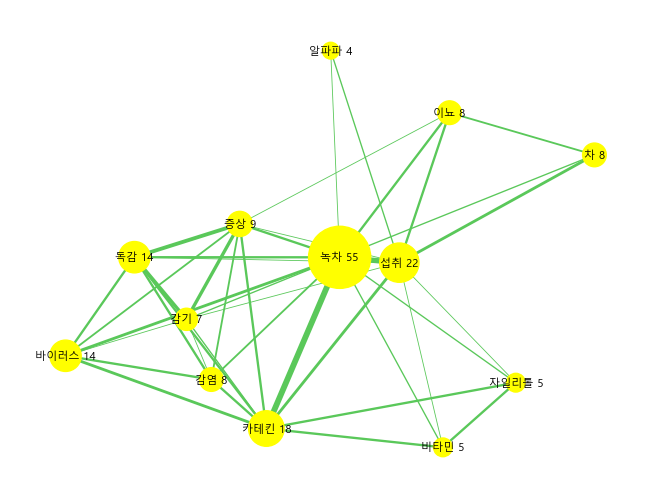

In [49]:
weights = nx.get_edge_attributes(G, "weight")
edges = G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 2000 

scaling_factor = 0.6 # to emphasise differences 
alphas = [(scale - weights[edge] + 1) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
#nx.draw_shell(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
nx.draw_spring(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

#pos=nx.spring_layout(G)
#nx.draw_networkx(G, pos=pos, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels, font_size=6)

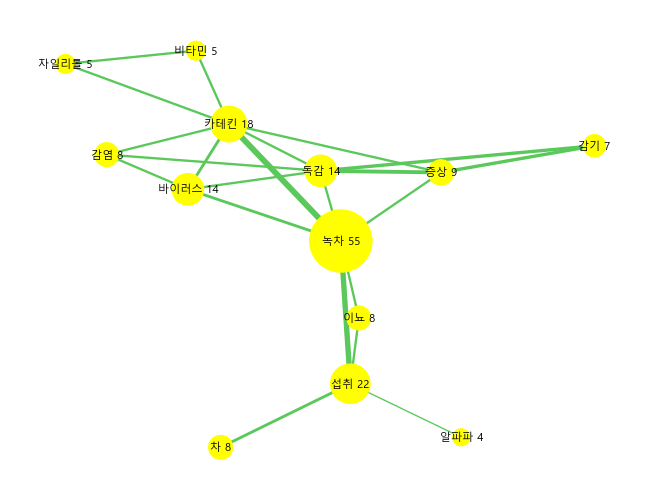

In [79]:
weights = nx.get_edge_attributes(cut_G, "weight")
edges = cut_G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(cut_G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 2000 

scaling_factor = 0.6 # to emphasise differences 
alphas = [(scale - weights[edge] + 1) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
#nx.draw_shell(cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
nx.draw_spring(cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

#pos=nx.spring_layout(cut_G)
#nx.draw_networkx(cut_G, pos=pos, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, with_labels=True, font_family=font_name)
#labels = nx.get_edge_attributes(cut_G,'weight')
#nx.draw_networkx_edge_labels(cut_G, pos=pos, edge_labels=labels, font_size=6)

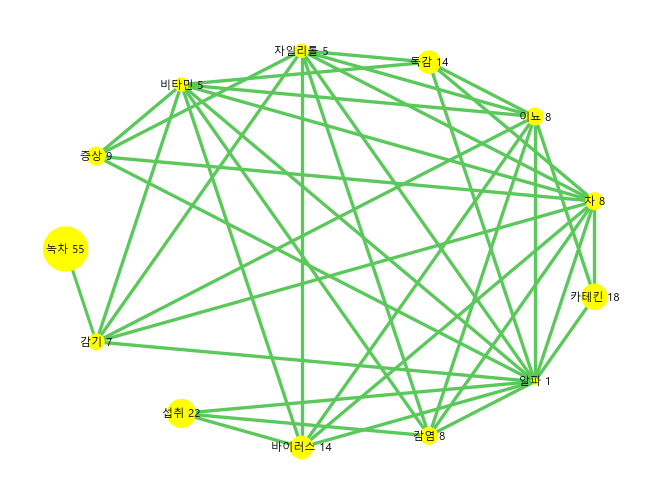

In [37]:
weights = nx.get_edge_attributes(percent_G, "weight")
edges = percent_G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(percent_G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 0.4 # to emphasise differences 
alphas = [(scale - weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
nx.draw_shell(percent_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#nx.draw_spring(percent_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

In [7]:
cut_G.degree

DegreeView({'녹차 55': 8, '섭취 22': 3, '카테킨 18': 7, '독감 14': 6, '바이러스 14': 4, '다이옥신 13': 1, '증상 9': 4, '감염 8': 3, '차 8': 1, '이뇨 8': 2, '감기 7': 2, '자일리톨 5': 2, '비타민 5': 2, '알파 1': 1})

In [8]:
percent_G.degree

DegreeView({'녹차 55': 7, '섭취 22': 3, '카테킨 18': 7, '독감 14': 6, '바이러스 14': 4, '다이옥신 13': 1, '증상 9': 4, '이뇨 8': 2, '차 8': 1, '감염 8': 3, '자일리톨 5': 2, '비타민 5': 2, '감기 7': 2})

In [9]:
G.degree

DegreeView({'녹차 55': 13, '섭취 22': 10, '카테킨 18': 10, '독감 14': 7, '바이러스 14': 6, '다이옥신 13': 3, '증상 9': 8, '감염 8': 6, '차 8': 3, '이뇨 8': 4, '감기 7': 7, '자일리톨 5': 4, '비타민 5': 4, '알파 1': 1})

In [10]:
{'id': 0, 'label': '감초', 'TF': 37}		{'id': 1, 'label': '효과', 'TF': 5}, 
{'id': 2, 'label': '글리시리진', 'TF': 11}	{'id': 3, 'label': '때', 'TF': 7}, 
{'id': 4, 'label': '함량', 'TF': 11}		{'id': 5, 'label': '일반', 'TF': 8}, 
{'id': 6, 'label': '복용', 'TF': 10}		{'id': 7, 'label': '부작용', 'TF': 4}, 
{'id': 8, 'label': '산', 'TF': 10}		{'id': 9, 'label': '수준', 'TF': 5}, 
{'id': 10, 'label': '기준', 'TF': 8}		{'id': 11, 'label': '엑스', 'TF': 5}, 
{'id': 12, 'label': '약재', 'TF': 11}		{'id': 13, 'label': '하루', 'TF': 5}, 
{'id': 14, 'label': '사용', 'TF': 7}		{'id': 15, 'label': '종', 'TF': 5}, 
{'id': 16, 'label': '한약', 'TF': 9}		{'id': 17, 'label': '애초', 'TF': 4}, 
{'id': 18, 'label': '경우', 'TF': 6}		{'id': 19, 'label': '약용', 'TF': 6}];


SyntaxError: invalid syntax (1678400943.py, line 1)